# Topic Modeling  Amazon Reviews 

In [1]:
import spacy
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
import unicodedata


In [2]:
df=pd.read_csv('clean_df.csv')
df.head()

,Score,Summary,Text,clean_text,count
0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,buy several vitality dog food products find go...,22
1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrive label jumbo salt peanuts peanut...,18
2,4,"""Delight"" says it all",This is a confection that has been around a fe...,confection around centuries light pillowy citr...,39
3,2,Cough Medicine,If you are looking for the secret ingredient i...,look secret ingredient robitussin believe find...,18
4,5,Great taffy,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...,13


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393576 entries, 0 to 393575
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Score       393576 non-null  int64 
 1   Summary     393576 non-null  object
 2   Text        393576 non-null  object
 3   clean_text  393573 non-null  object
 4   count       393576 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 15.0+ MB


In [4]:
#Size of the dataset
df.shape

(393576, 5)

In [5]:
#Drop unwanted columns
df.drop(['count','Summary'],axis=1,inplace=True)

In [6]:
#dropping duplicates
df.drop_duplicates(subset=['Text'],inplace=True)  
#dropping na
df.dropna(axis=0,inplace=True)  

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393573 entries, 0 to 393575
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Score       393573 non-null  int64 
 1   Text        393573 non-null  object
 2   clean_text  393573 non-null  object
dtypes: int64(1), object(2)
memory usage: 12.0+ MB


In [8]:
#final size of the dataset
df.shape

(393573, 3)

In [9]:
#sample review
df['Text'].iloc[0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [10]:
#To check the unique number of Score
df['Score'].unique()

array([5, 1, 4, 2, 3], dtype=int64)

In [11]:
#value_counts of score
df['Score'].value_counts()

5    250713
4     56042
1     36275
3     29752
2     20791
Name: Score, dtype: int64

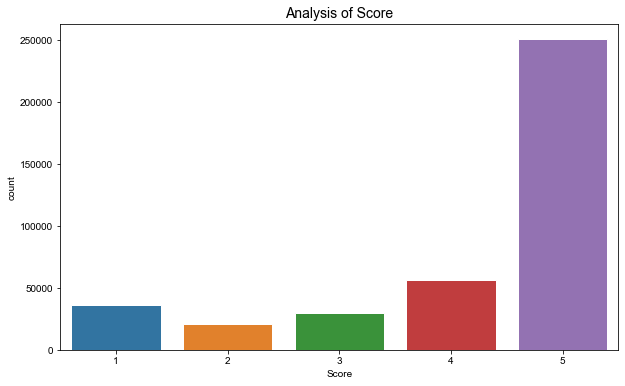

In [12]:
#countplot of score
plt.figure(figsize=(10,6))
plt.title('Analysis of Score',fontsize=14)
sns.set_style('whitegrid')
sns.countplot(x='Score',data=df)

From the countplot it is clear that most of the reviews have score 5 and very less reviwes have score 2

# Topic Modeling to Mining Amazon Reviews 

  Topic Modeling is a text mining approach. A Topic Model can be defined as an unsupervised technique to discover topics across various text documents. 
  Topic modeling helps in exploring large amounts of text data, finding clusters of words, similarity between documents, and discovering abstract topics. 
    
  Topic Modeling Algorithms
  
There are several algorithms for doing topic modeling. The most popular ones include
LSA or LSI – Latent Semantic Analysis or Latent Semantic Indexing – Uses Singular Value Decomposition (SVD) on the Document-Term Matrix. Based on Linear Algebra

NMF – Non-Negative Matrix Factorization – Based on Linear Algebra

LDA – Latent Dirichlet Allocation – The one we’ll be focusing here. Its foundations are Probabilistic Graphical Models
  

#### What does LDA do?

The LDA is based upon two general assumptions:

Documents that have similar words usually have the same topic

Documents that have groups of words frequently occurring together usually have the same topic.

LDA’s approach to topic modeling is it considers each document as a collection of topics in a certain proportion. And each topic as a collection of keywords, again, in a certain proportion.
Once you provide the algorithm with the number of topics, all it does it to rearrange the topics distribution within the documents and keywords distribution within the topics to obtain a good composition of topic-keywords distribution.
A topic is nothing but a collection of dominant keywords that are typical representatives. Just by looking at the keywords, you can identify what the topic is all about.

I will be using the Latent Dirichlet Allocation (LDA) from Gensim package.

In [13]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

#### Tokenize words

Let’s tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.
Gensim’s simple_preprocess() is great for this. Additionally I have set deacc=True to remove the punctuations.

In [14]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df['clean_text']))

print(data_words[:1])

[['buy', 'several', 'vitality', 'dog', 'food', 'products', 'find', 'good', 'quality', 'product', 'look', 'like', 'stew', 'process', 'meat', 'smell', 'better', 'labrador', 'finicky', 'appreciate', 'product', 'better']]


In [15]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['buy', 'several', 'vitality', 'dog', 'food', 'products', 'find', 'good', 'quality', 'product', 'look', 'like', 'stew', 'process', 'meat', 'smell', 'better', 'labrador', 'finicky', 'appreciate', 'product', 'better']


In [16]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [17]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [21]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
#nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
#data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_words_bigrams[:1])

[['buy', 'several', 'vitality', 'dog', 'food', 'products', 'find', 'good', 'quality', 'product', 'look', 'like', 'stew', 'process', 'meat', 'smell', 'better', 'labrador', 'finicky', 'appreciate', 'product', 'better']]


In [22]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)

# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1)]]


In [23]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('appreciate', 1),
  ('better', 2),
  ('buy', 1),
  ('dog', 1),
  ('find', 1),
  ('finicky', 1),
  ('food', 1),
  ('good', 1),
  ('labrador', 1),
  ('like', 1),
  ('look', 1),
  ('meat', 1),
  ('process', 1),
  ('product', 2),
  ('products', 1),
  ('quality', 1),
  ('several', 1),
  ('smell', 1),
  ('stew', 1),
  ('vitality', 1)]]

In [24]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [25]:
# Print the Keyword in the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.041*"like" + 0.040*"taste" + 0.032*"good" + 0.027*"flavor" + 0.025*"try" + 0.024*"would" + 0.022*"one" + 0.017*"tea" + 0.015*"really" + 0.014*"get"'), (1, '0.033*"love" + 0.032*"buy" + 0.030*"product" + 0.028*"great" + 0.026*"find" + 0.020*"order" + 0.019*"time" + 0.018*"get" + 0.018*"price" + 0.017*"box"'), (2, '0.031*"make" + 0.016*"eat" + 0.014*"add" + 0.013*"cookies" + 0.011*"sauce" + 0.011*"cookie" + 0.011*"mix" + 0.009*"sugar" + 0.008*"soft" + 0.008*"also"'), (3, '0.068*"coffee" + 0.034*"drink" + 0.025*"cup" + 0.023*"bean" + 0.015*"day" + 0.013*"roast" + 0.013*"strong" + 0.011*"blend" + 0.011*"dark" + 0.009*"morning"'), (4, '0.043*"food" + 0.030*"dog" + 0.024*"treat" + 0.018*"cat" + 0.016*"old" + 0.015*"eat" + 0.012*"hair" + 0.009*"salmon" + 0.009*"dry" + 0.008*"health"')]


In [26]:
for topic in range(0, 5):
    print(f"\nTopic {topic+1}:")
    for token, frequency in lda_model.show_topic(topic, topn=10):
        print(f" {token}, {frequency}")


Topic 1:
 like, 0.041212521493434906
 taste, 0.039847202599048615
 good, 0.03170450031757355
 flavor, 0.027232082560658455
 try, 0.02529573068022728
 would, 0.02414184808731079
 one, 0.022158855572342873
 tea, 0.017496056854724884
 really, 0.015455037355422974
 get, 0.014466571621596813

Topic 2:
 love, 0.03268346190452576
 buy, 0.03201187774538994
 product, 0.030239162966609
 great, 0.028007538989186287
 find, 0.0256668608635664
 order, 0.019710730761289597
 time, 0.01923275738954544
 get, 0.018145060166716576
 price, 0.017944319173693657
 box, 0.016777878627181053

Topic 3:
 make, 0.03073294460773468
 eat, 0.016306426376104355
 add, 0.013818901032209396
 cookies, 0.01323580089956522
 sauce, 0.01146496832370758
 cookie, 0.010840049013495445
 mix, 0.01054997555911541
 sugar, 0.009061293676495552
 soft, 0.007922213524580002
 also, 0.007645383011549711

Topic 4:
 coffee, 0.06816712021827698
 drink, 0.033673178404569626
 cup, 0.025338539853692055
 bean, 0.022748488932847977
 day, 0.01522

In [28]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.262422  0.272676       1        1  32.107658
2     -0.170167 -0.063086       2        1  24.577127
1      0.206253 -0.303046       3        1  23.974014
4      0.016295  0.029095       4        1   9.852240
3     -0.314804  0.064361       5        1   9.488970, topic_info=            Term           Freq          Total Category  logprob  loglift
391       coffee   95494.000000   95494.000000  Default  30.0000  30.0000
9           like  195353.000000  195353.000000  Default  29.0000  29.0000
196        taste  188881.000000  188881.000000  Default  28.0000  28.0000
7           good  150283.000000  150283.000000  Default  27.0000  27.0000
2            buy  113346.000000  113346.000000  Default  26.0000  26.0000
...          ...            ...            ...      ...      ...      ...
522          day   21334.716797   32408.486328   Topic5  -4.1845   1.9370
1177  absolutely   10163.030273   12635.597656   Topic5  -4.9261   2.1373
229         full    9399.747070   14994.986328   Topic5  -5.0042   1.8880
77          make   11554.934570  123066.085938   Topic5  -4.7977  -0.0106
414        water    9431.367188   34394.066406   Topic5  -5.0008   1.0612

[254 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
344       3  0.999922        able
1177      4  0.195638  absolutely
1177      5  0.804315  absolutely
418       2  0.999981         add
152       1  0.432215        also
...     ...       ...         ...
696       5  0.230160        work
122       1  0.999334       would
122       3  0.000655       would
243       3  0.899365       years
243       4  0.100606       years

[310 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 5, 4])

#### Creating Bigram and Trigram Models

Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold. The higher the values of these param, the harder it is for words to be combined to bigrams.

In [ ]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
data_words_bigrams = make_bigrams(data_words)
print(data_words_bigrams[6])

In [ ]:
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
trigram_mod = gensim.models.phrases.Phraser(trigram)
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
data_words_trigrams = make_trigrams(data_words)
print(data_words_trigrams[2])

#### Create the Dictionary and Corpus needed for Topic Modeling

Gensim creates a unique id for each word in the document. The first 10 words in our dictionary are as follows:

In [ ]:
from gensim.corpora.dictionary import Dictionary

vocabulary = Dictionary(data_words_bigrams)

vocabulary_keys = list(vocabulary.token2id)[0:10]

for key in vocabulary_keys:
    print(f"ID: {vocabulary.token2id[key]}, Token: {key}")

In order for a machine learning model to work with text input, the document must first be vectorized. So the input has to be converted into  numerical values.

#### Bag of Words Model

The classical approach in expressing text as a set of features is getting the token frequency. Each entry to the dataframe is a document while each column corresponds to every unique token in the entire corpora. The row will identify how many times a word appears in the document. 

In [ ]:
bow = [vocabulary.doc2bow(doc) for doc in data_words_bigrams]

for idx, freq in bow[0]:
    print(f"Word: {vocabulary.get(idx)}, Frequency: {freq}")

#### TF-IDF Model

Tf-idf stands for term frequency-inverse document frequency, and the tf-idf weight is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. 

In [ ]:
from gensim.models.tfidfmodel import TfidfModel

tfidf = TfidfModel(bow)

for idx, weight in tfidf[bow[0]]:
    print(f"Word: {vocabulary.get(idx)}, Weight: {weight:.3f}")

#### Shortcomings of count-based feature engineering model

Traditional count-based feature engineering models are bag of words and  TF-IDF. While they are effective methods for extracting features from text, due to the inherent nature of the model being just a bag of unstructured words, we lose additional information like the semantics, structure, sequence and context around nearby words in each text document.

#### The need for word embeddings

In case of raw text data, especially count based models like Bag of Words, we are dealing with individual words which may have their own identifiers and do not capture the semantic relationship amongst words. This leads to huge sparse word vectors for textual data and thus if we do not have enough data, we may end up getting poor models or even overfitting the data due to the curse of dimensionality.

Predictive methods like Neural Network based language models try to predict words from its neighboring words looking at word sequences in the corpus and in the process it learns distributed representations giving us dense word embeddings.

#### The Word2Vec Model

This is a predictive deep learning based model to compute and generate high quality, distributed and continuous dense vector representations of words, which capture contextual and semantic similarity. Essentially these are unsupervised models which can take in massive textual corpora, create a vocabulary of possible words and generate dense word embeddings for each word in the vector space representing that vocabulary. 

In [ ]:
from gensim.models import word2vec

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(data_words, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50,seed=42)



In [ ]:
# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['best', 'like', 'use', 'product', 'horrible', 'taste','price','dog']}
similar_words

To better appreciate the concept of word embeddings, I took eight common words in our corpora and derive their five most related words using our word_vec model. The similarity comes from how often these tokens appear in the same window of words as their similar_words counterpart.

#### t-SNE

t-Distributed Stochastic Neighbor Embedding (t-SNE) is an unsupervised, non-linear technique primarily used for data exploration and visualizing high-dimensional data.  t-SNE gives a feel or intuition of how the data is arranged in a high-dimensional space.

In [ ]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(20, 10))
plt.scatter(T[:, 0], T[:, 1])#, c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+3, y+3))


#### Word Algebra

Since Word2Vec characterizes words into quantified tokens, we can consequently add or subtract word vectors together. To add is to combine the meaning of the components and to subtract is to take out the context of one token from another. The following are examples of this vector algebra and their similarity scores:

##### Dog + Food

In [ ]:
w2v_model.wv.most_similar(positive=["dog", "food"], \
                      negative=[], topn=1)

##### Coffee + tea

In [ ]:
w2v_model.wv.most_similar(positive=["coffee",'tea'], \
                      negative=[], topn=1)

#### LDA

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=bow,
                                           id2word=vocabulary,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


In [ ]:
# Print the Keyword in the 10 topics
from pprint import pprint
pprint(lda_model.print_topics())
doc_lda = lda_model[bow]

In [ ]:
for topic in range(0, 5):
    print(f"\nTopic {topic+1}:")
    for token, frequency in lda_model.show_topic(topic, topn=10):
        print(f" {token}, {frequency}")

It means the top 10 keywords that contribute to this topic 3 are: ‘taste’, ‘like’, ‘good’.. and so on and the weight of ‘taste’ on topic 3 is 0.05.
The weights reflect how important a keyword is to that topic.

#### Visualize the topics-keywords

In [ ]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
import pyLDAvis.gensim

lda_idm = pyLDAvis.gensim.prepare(lda_model, bow, vocabulary)

pyLDAvis.display(lda_idm)

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.
A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.
A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.
The right-hand side bars represent the words,form the selected topic.